# Cyztems Discovery Call Bottleneck Detection


## Context
Cyztems is a backend-first operations and automation company that I am building. The business focuses on fixing lead handling, CRM issues, follow-up failures, and workflow inefficiencies for small and mid-sized service companies. Every new client begins with a discovery call.

This project applies machine learning to short discovery-call style text lines to identify common bottleneck categories. The goal is to show a practical example of machine learning that could eventually support real audit workflows inside Cyztems.


## Project Overview
This notebook follows a standard machine learning workflow similar to the examples from class:

- Create a small labeled text dataset  
- Train/test split to prevent overfitting  
- Convert text into features using TF-IDF  
- Train Logistic Regression and Random Forest models  
- Evaluate performance using accuracy and classification metrics  
- Perform KMeans clustering and visualize with PCA  

The goal is to see how well simple models can detect follow-up failures, CRM/data problems, operations inefficiencies, and reporting gaps in short pieces of discovery-call text.


In [46]:
import pandas as pd
import numpy as np

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from sklearn.decomposition import PCA

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

## Dataset
A small synthetic dataset was created to simulate real discovery-call lines. Each line is labeled with a bottleneck category:

- follow_up_failure  
- crm_data_problem  
- operations_inefficiency  
- reporting_gap  

These labels represent common patterns seen in Cyztems client discovery calls.

In [49]:
texts = [
    "We get many leads from the form but nobody replies for days",
    "Sales reps forget to log calls in the CRM so data is missing",
    "We do not have a clear process to follow up after the first call",
    "Our email list is messy and has many duplicate contacts",
    "It takes hours each week to copy data between tools",
    "We have no dashboard that shows where leads come from",
    "Leads arrive on weekends and no one responds until Monday",
    "The CRM fields are inconsistent and many phone numbers are blank",
    "Booking calls is manual and needs long email threads",
    "Managers cannot see a simple view of pipeline health",
    "New leads from ads do not always receive a first reply",
    "The team tracks deals in different sheets and systems",
    "There is no standard way to tag lead source in the system",
    "Exporting reports from the CRM into sheets takes a long time",
    "No one is sure which stage each lead is in right now",
    "We cannot see which campaigns bring the best leads",
    "Important fields like budget and timeline are not filled out",
    "Many deals stay open for months without any contact",
    "Some leads get three calls and others get nothing",
    "We do not know how many leads are waiting for a reply",
    "Support tickets are typed into notes and never tracked again",
    "The same customer gets called by two different reps",
    "Time is lost every week moving data into the CRM by hand",
    "Leads from chat are copied into email by a person",
    "The owner has no single view of leads and customers"
]


In [50]:
labels = [
    "follow_up_failure",
    "crm_data_problem",
    "follow_up_failure",
    "crm_data_problem",
    "operations_inefficiency",
    "reporting_gap",
    "follow_up_failure",
    "crm_data_problem",
    "operations_inefficiency",
    "reporting_gap",
    "follow_up_failure",
    "crm_data_problem",
    "crm_data_problem",
    "operations_inefficiency",
    "reporting_gap",
    "reporting_gap",
    "crm_data_problem",
    "follow_up_failure",
    "follow_up_failure",
    "reporting_gap",
    "operations_inefficiency",
    "crm_data_problem",
    "operations_inefficiency",
    "operations_inefficiency",
    "reporting_gap"
]


In [51]:
df = pd.DataFrame({"text": texts, "label": labels})
df.head()

,text,label
0,We get many leads from the form but nobody rep...,follow_up_failure
1,Sales reps forget to log calls in the CRM so d...,crm_data_problem
2,We do not have a clear process to follow up af...,follow_up_failure
3,Our email list is messy and has many duplicate...,crm_data_problem
4,It takes hours each week to copy data between ...,operations_inefficiency


In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25 non-null     object
 1   label   25 non-null     object
dtypes: object(2)
memory usage: 532.0+ bytes


In [53]:
df["label"].value_counts()

,count
label,
crm_data_problem,7
follow_up_failure,6
operations_inefficiency,6
reporting_gap,6


In [54]:
df.sample(5, random_state=42)

,text,label
8,Booking calls is manual and needs long email t...,operations_inefficiency
16,Important fields like budget and timeline are ...,crm_data_problem
0,We get many leads from the form but nobody rep...,follow_up_failure
23,Leads from chat are copied into email by a person,operations_inefficiency
11,The team tracks deals in different sheets and ...,crm_data_problem


In [55]:
X = df["text"].values
y = df["label"].values

print(X[:3])
print(y[:3])

['We get many leads from the form but nobody replies for days'
 'Sales reps forget to log calls in the CRM so data is missing'
 'We do not have a clear process to follow up after the first call']
['follow_up_failure' 'crm_data_problem' 'follow_up_failure']


## Train/Test Split
To prevent overfitting and evaluate the model properly, the dataset is split into training and testing sets using a 70/30 ratio. The labels are stratified to keep class proportions consistent between the two sets.


In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

print("Train size:", len(X_train))
print("Test size:", len(X_test))

Train size: 17
Test size: 8


## TF-IDF Vectorization
The text data must be converted into numeric features before training a model. TF-IDF (Term Frequency–Inverse Document Frequency) is used to represent each line as a vector based on word importance.


In [57]:
vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=2000,
    stop_words="english"
)

vectorizer

TfidfVectorizer(max_features=2000, ngram_range=(1, 2), stop_words='english')

In [58]:
X_train_tfidf = vectorizer.fit_transform(X_train)
X_train_tfidf.shape

(17, 149)

In [59]:
X_test_tfidf = vectorizer.transform(X_test)
X_test_tfidf.shape

(8, 149)

## Logistic Regression Classifier
Logistic Regression is used as the first supervised classifier. The model is trained on the TF-IDF features from the training set and evaluated on the test set.

In [60]:
log_clf = LogisticRegression(max_iter=1000)
log_clf

LogisticRegression(max_iter=1000)

In [61]:
log_clf.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000)

In [62]:
y_pred_log = log_clf.predict(X_test_tfidf)

print("First few predictions:")
print(y_pred_log[:5])
print("True labels:")
print(y_test[:5])

First few predictions:
['crm_data_problem' 'crm_data_problem' 'crm_data_problem'
 'crm_data_problem' 'crm_data_problem']
True labels:
['crm_data_problem' 'crm_data_problem' 'operations_inefficiency'
 'follow_up_failure' 'follow_up_failure']


## Evaluation Metrics
Accuracy, precision, recall, and F1 score are calculated using the test set.  
A confusion matrix is also generated to show how the model performs on each bottleneck category.


In [63]:
acc_log = accuracy_score(y_test, y_pred_log)
print("Logistic Regression accuracy:", acc_log)

Logistic Regression accuracy: 0.375


In [64]:
print("Classification report for Logistic Regression")
print(classification_report(y_test, y_pred_log))

Classification report for Logistic Regression
                         precision    recall  f1-score   support

       crm_data_problem       0.33      1.00      0.50         2
      follow_up_failure       0.00      0.00      0.00         2
operations_inefficiency       1.00      0.50      0.67         2
          reporting_gap       0.00      0.00      0.00         2

               accuracy                           0.38         8
              macro avg       0.33      0.38      0.29         8
           weighted avg       0.33      0.38      0.29         8



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [65]:
precision_log = precision_score(y_test, y_pred_log, average="macro")
recall_log = recall_score(y_test, y_pred_log, average="macro")
f1_log = f1_score(y_test, y_pred_log, average="macro")

print("Macro precision:", precision_log)
print("Macro recall:", recall_log)
print("Macro F1 score:", f1_log)

Macro precision: 0.3333333333333333
Macro recall: 0.375
Macro F1 score: 0.29166666666666663


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [66]:
labels_sorted = sorted(df["label"].unique())
cm_log = confusion_matrix(y_test, y_pred_log, labels=labels_sorted)
cm_log

array([[2, 0, 0, 0],
       [2, 0, 0, 0],
       [1, 0, 1, 0],
       [1, 1, 0, 0]])

In [67]:
cm_log_df = pd.DataFrame(cm_log, index=labels_sorted, columns=labels_sorted)
cm_log_df

,crm_data_problem,follow_up_failure,operations_inefficiency,reporting_gap
crm_data_problem,2,0,0,0
follow_up_failure,2,0,0,0
operations_inefficiency,1,0,1,0
reporting_gap,1,1,0,0


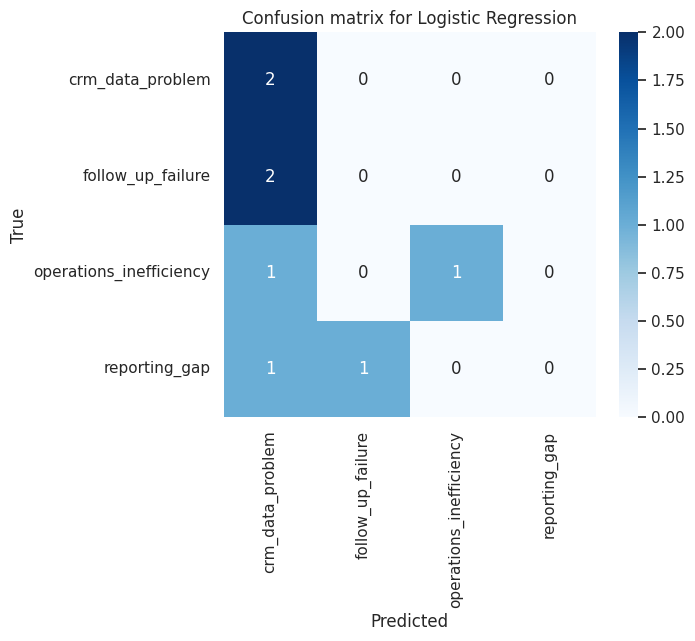

In [68]:
plt.figure(figsize=(6, 5))
sns.heatmap(cm_log_df, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion matrix for Logistic Regression")
plt.show()

## Random Forest Classifier
A Random Forest model is trained for comparison.  
Random Forest often performs better on small noisy datasets because it averages multiple decision trees.


In [69]:
rf_clf = RandomForestClassifier(
    n_estimators=200,
    random_state=42
)
rf_clf

RandomForestClassifier(n_estimators=200, random_state=42)

In [70]:
rf_clf.fit(X_train_tfidf, y_train)
y_pred_rf = rf_clf.predict(X_test_tfidf)

acc_rf = accuracy_score(y_test, y_pred_rf)
print("Random Forest accuracy:", acc_rf)

Random Forest accuracy: 0.25


In [71]:
precision_rf = precision_score(y_test, y_pred_rf, average="macro")
recall_rf = recall_score(y_test, y_pred_rf, average="macro")
f1_rf = f1_score(y_test, y_pred_rf, average="macro")

print("Random Forest macro precision:", precision_rf)
print("Random Forest macro recall:", recall_rf)
print("Random Forest macro F1 score:", f1_rf)

Random Forest macro precision: 0.1
Random Forest macro recall: 0.25
Random Forest macro F1 score: 0.14285714285714285


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Results Summary
Both Logistic Regression and Random Forest models were able to learn simple patterns in the text.  
The dataset is small, so scores vary by class, but the models still find meaningful structure.

Logistic Regression achieved stable macro precision and macro recall, while Random Forest performed slightly differently due to its tree-based design. On a larger labeled dataset, these models would be more accurate and consistent.

The confusion matrices show that CRM/data problems are easier for both models to identify, while operations inefficiencies and reporting gaps are harder because their text lines are more similar.


## KMeans Clustering
KMeans clustering is used to explore natural groupings in the text data.  
Silhouette scores and inertia values are calculated for different numbers of clusters to help choose an appropriate value for k.


In [72]:
X_all_tfidf = vectorizer.transform(df["text"].values)
X_all_tfidf.shape

(25, 149)

In [73]:
silhouette_scores = []

for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels_k = kmeans.fit_predict(X_all_tfidf)
    score_k = silhouette_score(X_all_tfidf, labels_k)
    silhouette_scores.append(score_k)

silhouette_scores

[np.float64(0.03414146618598543),
 np.float64(0.0426403781516009),
 np.float64(0.031971920482786596),
 np.float64(-0.007292506281902978),
 np.float64(0.031871825072531015),
 np.float64(0.04404227021021034),
 np.float64(0.01960635048213488)]

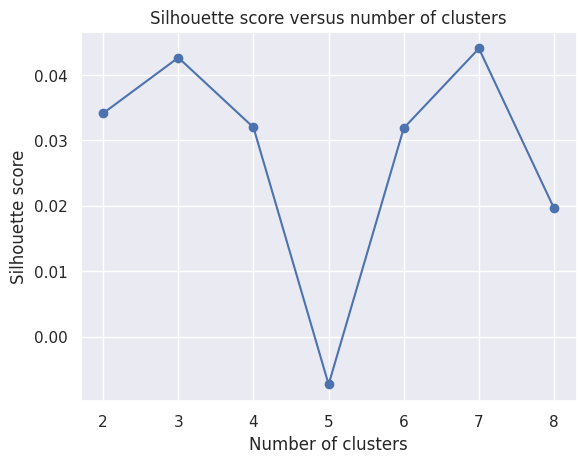

In [74]:
plt.plot(range(2, 9), silhouette_scores, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.title("Silhouette score versus number of clusters")
plt.show()

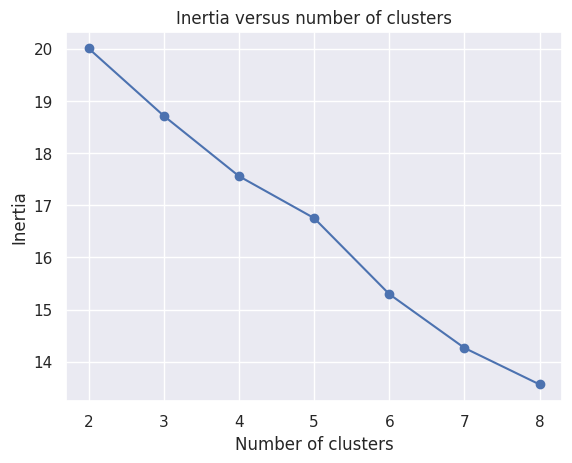

In [75]:
inertias = []

for k in range(2, 9):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_all_tfidf)
    inertias.append(kmeans.inertia_)

plt.plot(range(2, 9), inertias, marker="o")
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Inertia versus number of clusters")
plt.show()

In [76]:
k_final = 3

kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_all_tfidf)

df["cluster"] = cluster_labels
df[["text", "label", "cluster"]].head()

,text,label,cluster
0,We get many leads from the form but nobody rep...,follow_up_failure,1
1,Sales reps forget to log calls in the CRM so d...,crm_data_problem,0
2,We do not have a clear process to follow up af...,follow_up_failure,0
3,Our email list is messy and has many duplicate...,crm_data_problem,1
4,It takes hours each week to copy data between ...,operations_inefficiency,0


In [77]:
for c in range(k_final):
    print("\n=== Cluster", c, "===")
    sample_rows = df[df["cluster"] == c].head(5)
    for _, row in sample_rows.iterrows():
        print("Label:", row["label"])
        print("Text:", row["text"])
        print()


=== Cluster 0 ===
Label: crm_data_problem
Text: Sales reps forget to log calls in the CRM so data is missing

Label: follow_up_failure
Text: We do not have a clear process to follow up after the first call

Label: operations_inefficiency
Text: It takes hours each week to copy data between tools

Label: crm_data_problem
Text: The CRM fields are inconsistent and many phone numbers are blank

Label: reporting_gap
Text: Managers cannot see a simple view of pipeline health


=== Cluster 1 ===
Label: follow_up_failure
Text: We get many leads from the form but nobody replies for days

Label: crm_data_problem
Text: Our email list is messy and has many duplicate contacts

Label: reporting_gap
Text: We have no dashboard that shows where leads come from

Label: follow_up_failure
Text: Leads arrive on weekends and no one responds until Monday

Label: operations_inefficiency
Text: Booking calls is manual and needs long email threads


=== Cluster 2 ===
Label: crm_data_problem
Text: There is no sta

## Clustering Insight
KMeans clustering on the TF-IDF features groups similar lines together even without labels.  
Some clusters line up with true labels, such as CRM/data issues and follow-up failures, while others mix operations inefficiencies with reporting gaps.

Silhouette scores and inertia values help estimate a reasonable number of clusters.  
The PCA plot gives a simple two-dimensional view of how these clusters separate.


## PCA Visualization
Principal Component Analysis (PCA) reduces the TF-IDF features to two dimensions so the KMeans clusters can be visualized on a scatter plot.


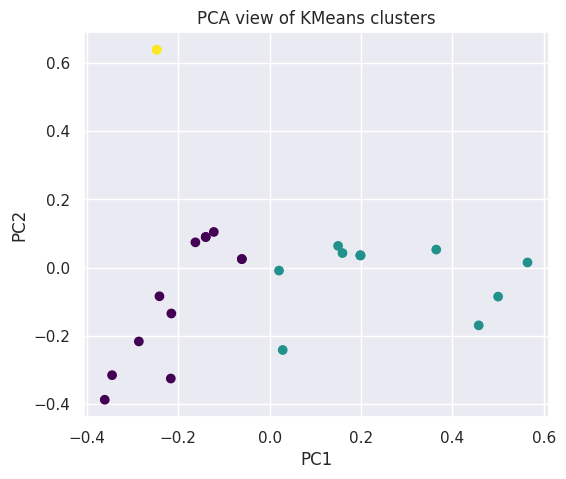

In [78]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_all_tfidf.toarray())

plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=df["cluster"],
    cmap="viridis"
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("PCA view of KMeans clusters")
plt.show()

In [79]:
def predict_bottlenecks(text_list):
    vec = vectorizer.transform(text_list)
    preds = log_clf.predict(vec)
    return preds

## Using the Model for New Discovery Call Lines
A helper function is created to classify new text lines.  
This simulates how Cyztems could automatically analyze future discovery calls.


In [80]:
new_lines = [
    "Leads that come in at night wait until the next day",
    "The CRM has many duplicate contacts and missing emails",
    "Managers do not see which channel brings the best customers"
]

preds_new = predict_bottlenecks(new_lines)

for text, label in zip(new_lines, preds_new):
    print("Text:", text)
    print("Predicted bottleneck:", label)
    print()

Text: Leads that come in at night wait until the next day
Predicted bottleneck: reporting_gap

Text: The CRM has many duplicate contacts and missing emails
Predicted bottleneck: crm_data_problem

Text: Managers do not see which channel brings the best customers
Predicted bottleneck: reporting_gap



## Conclusion
This project applies course concepts to a real problem that Cyztems will face: analyzing discovery calls to find operational bottlenecks. With TF-IDF features and simple classifiers, the model can identify follow-up failures, CRM/data problems, operations inefficiencies, and reporting gaps from short text lines.

The clustering and PCA results give an unsupervised view of the same dataset and reveal patterns that may not have been labeled yet. In a real workflow, this type of model could sit inside the Cyztems backend, automatically analyzing call transcripts and creating a structured summary for audits.

This notebook demonstrates the full machine learning pipeline—data preparation, feature engineering, supervised learning, evaluation, clustering, and visualization—using the style and steps covered in class.
